## Welcome back to Python Notebooks!

Didja miss me??

### And welcome to Week 4, Day 2 - introducing LangGraph!

In [1]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
import random


In [2]:
# Some useful constants

nouns = ["Cabbages", "Unicorns", "Toasters", "Penguins", "Bananas", "Zombies", "Rainbows", "Eels", "Pickles", "Muffins"]
adjectives = ["outrageous", "smelly", "pedantic", "existential", "moody", "sparkly", "untrustworthy", "sarcastic", "squishy", "haunted"]

In [3]:
# Our favorite first step! Crew was doing this for us, by the way.
load_dotenv(override=True)


True

In [4]:
def shout(text: Annotated[str, "something to be shouted"]) -> str:
    print(text.upper())
    return text.upper()

shout("hello")

HELLO


'HELLO'

## 1. What is `Annotated`?

`Annotated` comes from the Python `typing` module and allows you to attach **metadata** to a data type hint.<br>
annotated with type hint and metadata.

Syntax:
```python
Annotated[<data type>, <metadata>]
```

Example:
```python
from typing import Annotated

UserId = Annotated[int, "this is a user ID"]
```
Here, the base type is `int`, but it carries extra information for frameworks or tools.

---

## 2. How it works in your code

```python
class State(BaseModel):
    messages: Annotated[list, add_messages]
```

- `messages` has the **type** `list`.
- `add_messages` is **metadata** attached to the field: reducer function for the field in your state.
- Pydantic or other libraries can use this metadata for validation, transformation, or documentation.


LangGraph needs us to use this feature when we define our State object.

It wants us to tell it what function it should call to update the State with a new value.

Q. What is **reducer** function?<br>
your reducer function (`add_messages`) decides how to combine the new state and old state: it can append it to old state or it can overwrite the old state.<br>
you can use builtin reducer functions or you can define custom reducer functions.

Q. what does `add_messages` do?<br>
A. It adds (appends) new messages to the list of messages (to the list of variable).

LangGraph provides a default reducer called `add_messages` which takes care of the most common case.


---

### Step 1: Define the State object

You can use any python object;<br>
but it's most common to use
- a TypedDict or 
- a Pydantic BaseModel.

In [5]:
class State(BaseModel):
        
    messages: Annotated[list, add_messages]


Q. what `messages: Annotated[list, add_messages]` means?<br>
A. it is annotated with data type (which is List) and metadata which is the reducer function that I need to use.

### Step 2: Start the Graph Builder with this State class

In [6]:
graph_builder = StateGraph(State)

Instantiating a state graph passing in state.<br>
And one thing to to get your head around here is that what I'm passing in there.it's not an object I'm not instantiating. I'm not I'm not creating a state and passing that in with with messages and so on.<br> 
Now I'm passing in the class. I'm passing in the type of thing that represents our state. That is what I'm using to create my state graph. And this is beginning the graph building process.

### Step 3: Create a Node

A node can be any python function.

The reducer that we set before gets automatically called to combine this response with previous responses


In [7]:
def our_first_node(old_state: State) -> State:

    reply = f"{random.choice(nouns)} are {random.choice(adjectives)}"
    messages = [{
        "role": "assistant", 
        "content": reply
        }]

    new_state = State(messages=messages)

    return new_state

graph_builder.add_node("first_node", our_first_node)

### Step 4: Create Edges

In [8]:
graph_builder.add_edge(START, "first_node")
graph_builder.add_edge("first_node", END)

Q. what are `START` and `END`?<br>
START and END are predefined constants that represent the start and end points of a workflow.<br>
In other words, START marks where the workflow begins, and END indicates where it concludes.

In [9]:
print(f'START: {START} , END: {END}')

START: __start__ , END: __end__


### Step 5: Compile the Graph

In [10]:
graph = graph_builder.compile()

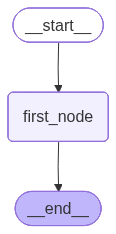

In [11]:
display(Image(graph.get_graph().draw_mermaid_png()))

### That's it! Showtime!

In [12]:
def chat(user_input: str, history):
    message = {"role": "user", "content": user_input}
    messages = [message]
    state = State(messages=messages)
    result = graph.invoke(state)
    print(result)
    return result["messages"][-1].content


# gr.ChatInterface(chat, type="messages").launch()

Q. what are types of `Messages` in LangGraph?<br>

## Types of Messages in LangGraph

LangGraph uses **messages** as structured communication units that flow through the graph.<br>
Messages are pre-defined communication units in the graph.<br>
They capture user input, model responses, tool outputs, and system instructions — forming the “conversation history” of the workflow.

---

#### 1. HumanMessage

**What it is:** human/ user input, A message sent by a human/user.  
**Role:** `user` or `human`.

```python
from langchain_core.messages import HumanMessage

msg = HumanMessage(content="What’s the weather like in Vancouver today?")
```

**Use case:** When a human initiates a query or gives instructions to the agent.

---

#### 2. AIMessage

**What it is:** AI model response, A message produced by the AI model (LLM).  
**Role:** `assistant` or `AI`.

```python
from langchain_core.messages import AIMessage

msg = AIMessage(content="It’s currently 12 °C in Vancouver with clouds and light rain.")
```

**Use case:** When the model responds to the user or processes workflow results.

---

#### 3. SystemMessage

**What it is:** system instruction, A message that sets system-level context, instructions, or configuration.  
**Role:** `system`.

```python
from langchain_core.messages import SystemMessage

msg = SystemMessage(content="You are a helpful assistant specialised in Canadian weather.")
```

**Use case:** Used at the start or during workflow to define AI behavior or persona.

---

#### 4. ToolMessage

**What it is:** tool output, Represents the result of a tool invocation.  
**Role:** `tool`.

```python
from langchain_core.messages import ToolMessage

tool_output = {"city": "Vancouver", "temp": 12, "condition": "cloudy and rain"}
msg = ToolMessage(content=str(tool_output), tool_call_id="weather_lookup_123")
```

**Use case:** When the graph executes a tool and you want to store its output as part of the state.

---

#### 5. RemoveMessage

**What it is:** Used to programmatically remove previous messages from the history.  
**Role:** *(none / system)*

```python
from langchain_core.messages import RemoveMessage

msg = RemoveMessage(id="msg_2025_10_19_0001")
```

**Use case:** Remove irrelevant or redundant messages to save tokens or fix context errors.

---

#### 6. AIMessageChunk

**What it is:** A chunked or streaming part of an AI response.  
**Role:** `assistant (partial)`.

```python
from langchain_core.messages import AIMessageChunk

chunk1 = AIMessageChunk(content="Here is the first part of the answer…")
chunk2 = AIMessageChunk(content="…and here is the continuation.")
```

**Use case:** When streaming partial responses token-by-token.

---

#### Example Conversation Flow

```python
SystemMessage(content="You are a helpful assistant that answers weather queries in Vancouver.")
HumanMessage(content="What’s the weather in Vancouver right now?")
ToolMessage(content="{'city': 'Vancouver', 'temp': 12, 'condition': 'cloudy and rain'}", tool_call_id="weather_lookup_1")
AIMessage(content="It’s currently 12 °C in Vancouver with cloudy skies and light rain. Would you like the hourly forecast?")
```

---

#### Summary Table:
**NOTE**: when you create chat based prompt, your role should be one of the following roles.<br>
**NOTE**: based on the role, LangGraph build a coresponding obejct of message. example:
```python
initial message = State(messages=[{"role": "human", "content": user_input}])
```
gives `[HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='aa')]`


| Message Type       | Role ("who")        | Use Case                                |
|--------------------|---------------------|------------------------------------------|
| `HumanMessage`     | user / human        | User asks a question or gives instructions |
| `AIMessage`        | assistant / AI      | LLM generates a response                  |
| `SystemMessage`    | system              | Set up instructions or global context     |
| `ToolMessage`      | tool                | Output of a tool invocation               |
| `RemoveMessage`    | (none / system)     | Remove or prune prior messages            |
| `AIMessageChunk`   | assistant (partial) | Streaming responses token‑by‑token        |

---


In [13]:
from langchain_core.messages import HumanMessage

msg = HumanMessage(content="What’s the weather like in Vancouver today?")

print(msg)

content='What’s the weather like in Vancouver today?' additional_kwargs={} response_metadata={}


### But why did I show you that?

To make the point that LangGraph is all about python functions - it doesn't need to involve LLMs!!

Now we'll do the 5 steps again, but in 1 shot:

In [14]:
# Step 1: Define the State object
class State(BaseModel):
    messages: Annotated[list, add_messages]

In [15]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)


In [16]:
# Step 3: Create a Node

llm = ChatOpenAI(model="gpt-4o-mini")

def chatbot_node(old_state: State) -> State:
    print(f'old message passed to LLM: \n{old_state}')
    response = llm.invoke(old_state.messages)
    print(f'response from llm: \n{response}')
    new_state = State(messages=[response])
    return new_state

graph_builder.add_node("chatbot", chatbot_node)

In [17]:
# Step 4: Create Edges
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

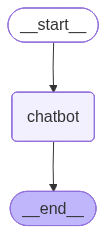

In [18]:
# Step 5: Compile the Graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### That's it! And, let's do this:

In [19]:
def chat(user_input: str, history):
    initial_state = State(messages=[{"role": "user", "content": user_input}])
    result = graph.invoke(initial_state)
    print(result)
    return result['messages'][-1].content


# gr.ChatInterface(chat, type="messages").launch()

gradio behavior purely in python

In [20]:

def chat(user_input: str, history):
    # Initialize the graph state with a new user message
    initial_state = State(messages=[{"role": "user", "content": user_input}])
    
    # Run the LangGraph
    result = graph.invoke(initial_state)
    print(f'result in chat function:\n{result}')
    
    # result["messages"] is likely a list of `BaseMessage` objects (AIMessage, HumanMessage, etc.)
    last_msg = result["messages"][-1]
    
    # Safely get the text content depending on object type
    content = getattr(last_msg, "content", None)
    if content is None and isinstance(last_msg, dict):
        content = last_msg.get("content")
    
    return content


def run_chat():
    print("Chat started. Type 'exit' to quit.\n")
    history = []

    while True:
        user_input = input("You: ").strip()
        if user_input.lower() in ["exit", "quit", "bye"]:
            print("Chat ended.")
            break

        response = chat(user_input, history)
        history.append({"role": "user", "content": user_input})
        history.append({"role": "assistant", "content": response})

        print(f"Assistant: {response}\n")


# Run the chat
run_chat()


Chat started. Type 'exit' to quit.

old message passed to LLM: 
messages=[HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='88f56607-e72e-4676-a107-af39a46bf54b')]
response from llm: 
content='Hello! How can I assist you today?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_ee69c2ef48', 'id': 'chatcmpl-CnuN6eVIVl6V1kxLE1aGs23ZfkX5D', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--de94f4a0-17e0-45b4-a962-73307f43d2c0-0' usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audi

In [ ]:

def chat(user_input: str, history):
    # Initialize the graph state with a new user message
    initial_state = State(messages=[{"role": "ai", "content": user_input}])
    
    # Run the LangGraph
    result = graph.invoke(initial_state)
    print(f'result in chat function:\n{result}')
    
    # result["messages"] is likely a list of `BaseMessage` objects (AIMessage, HumanMessage, etc.)
    last_msg = result["messages"][-1]
    
    # Safely get the text content depending on object type
    content = getattr(last_msg, "content", None)
    if content is None and isinstance(last_msg, dict):
        content = last_msg.get("content")
    
    return content


def run_chat():
    print("Chat started. Type 'exit' to quit.\n")
    history = []

    while True:
        user_input = input("You: ").strip()
        if user_input.lower() in ["exit", "quit", "bye"]:
            print("Chat ended.")
            break

        response = chat(user_input, history)
        history.append({"role": "user", "content": user_input})
        history.append({"role": "assistant", "content": response})

        print(f"Assistant: {response}\n")


# Run the chat
run_chat()


Chat started. Type 'exit' to quit.

old message passed to LLM: 
messages=[AIMessage(content='hi', additional_kwargs={}, response_metadata={}, id='aefe7ca1-9708-42e5-b933-8eeb4e00c794')]
response from llm: 
content='Hello! How can I assist you today?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-CSdIodgXeoY7AUCO8vEfXb0a8GlUp', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--43a09595-7eb5-4773-afc4-a77e9cba0f63-0' usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio':